<a href="https://colab.research.google.com/github/MLLSCKR/GAN-Related-Paper-Repository/blob/master/ConditionalGAN(CGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = "GenerativeModels/Fundamentals/CGAN_RESULTS"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

import os

os.chdir('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Conditional GAN(CGAN)

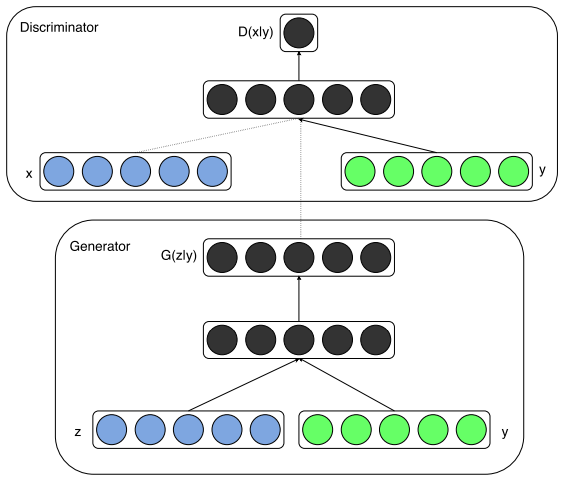

$$\min_G\max_D V(D, G)=\mathbb{E}_{x\sim p_{data}(x)}[\log D(x|y)]+\mathbb{E}_{z\sim p_z(z)}[\log(1-D(G(z|y)))]$$

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

논문에 나와 있는대로 모델 구현을 위해서는 convolution model을 사용해야하나, pre-trained model을 적용하는 방식이기에 pretrained convolution model을 찾기 위해 고군분투하는 것 보다 아래와 같이 약식으로 model 구현하였다.

In [52]:
# Hyper-parameters
num_epoch = 200
batch_size = 64
learning_rate = 0.0001
img_size = 28*28
num_channel = 1
noise_size = 100
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
condition_size = 10

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [53]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.linear1 = nn.Linear(img_size + condition_size, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, 1)
    self.relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.linear3(x)
    x = self.sigmoid(x)
    return x

In [54]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.linear1 = nn.Linear(noise_size + condition_size, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, img_size)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.linear3(x)
    x = self.tanh(x)
    return x #generated image

In [55]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from PIL import Image, ImageFont, ImageDraw

In [56]:
import torchvision.transforms as transforms

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std = [0.5])
])

mnist_root = './'

train_dataset = MNIST(mnist_root, transform=transform, train=True, download=True)
test_dataset = MNIST(mnist_root, transform=transform, train=False, download=True)

In [57]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

### Define Model

In [58]:
discriminator = Discriminator()
generator = Generator()

discriminator = discriminator.to(device)
generator = generator.to(device)

### Loss function and Optimizer setting

In [59]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = learning_rate)
g_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate)

### Training

In [60]:
import numpy as np

In [61]:
font = ImageFont.load_default()

In [62]:
for epoch in range(num_epoch):
  d_performance = []
  g_performance = []

  for i, (images, label) in enumerate(train_loader):
    loaded_batch_size = images.shape[0]

    # make ground truth (labels) -> 1 for real, 0 for fake
    real_label = torch.full((loaded_batch_size, 1), 1, dtype = torch.float32).to(device)
    fake_label = torch.full((loaded_batch_size, 1), 0, dtype = torch.float32).to(device)

    # reshpae real images from MNIST dataset
    real_images = images.reshape(loaded_batch_size, -1).to(device)

    # Encode MNIST's label's with 'one hot encoding'
    label_encoded = F.one_hot(label, num_classes = 10).to(device)
    # concat real images with 'label_encoded' vector
    real_images_concat = torch.cat((real_images, label_encoded), 1)

    ############################################################################
    # Train Discriminator
    ############################################################################

    # initialize grad
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

    # make fake images with generator & noise vecotr 'z'
    z = torch.randn(loaded_batch_size, noise_size).to(device)
    # concat noise vector z with encoded labels
    z_concat = torch.cat((z, label_encoded), 1)

    # generate fake images
    fake_images = generator(z_concat)
    fake_images_concat = torch.cat((fake_images, label_encoded), 1)

    # calculate fake and real loss with generated images above & real images
    fake_loss = criterion(discriminator(fake_images_concat), fake_label)
    real_loss = criterion(discriminator(real_images_concat), real_label)

    d_loss = (fake_loss + real_loss) / 2

    # train discriminator with backpropagation
    d_loss.backward()
    d_optimizer.step()

    ############################################################################
    # Train Generator
    ############################################################################

    # initialize grad
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

    # noise z
    z = torch.randn(loaded_batch_size, noise_size).to(device)
    # concat noise vector z with encoded labels
    z_concat = torch.cat((z, label_encoded), 1)

    # generate fake images
    fake_images = generator(z_concat)
    fake_images_concat = torch.cat((fake_images, label_encoded), 1)

    # compare result of discriminator with fake images and real labels
    g_loss = criterion(discriminator(fake_images_concat), real_label)

    # train generator with backpropagation
    g_loss.backward()
    g_optimizer.step()

    d_performance.append(discriminator(real_images_concat).mean().item())
    g_performance.append(discriminator(fake_images_concat).mean().item())

    if (i + 1) % 100 == 0:
      print("Epoch [{}/{}] Step [{}/{}] d_loss: {:.5f} g_loss: {:.5f}"
            .format(epoch+1, num_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item()))

  # print discriminator and generator's performance
  print("Epoch {}'s discriminator performance: {:.2f} generator performance: {:.2f}"
        .format(epoch+1, np.mean(d_performance), np.mean(g_performance)))

  # save fake images in each epoch
  samples = fake_images.reshape(loaded_batch_size, 1, 28, 28)
  save_image(samples, 'CGAN_fake_samples{}.png'.format(epoch+1))

  # draw real labels on fake smaple images
  fake_sample_image = Image.open('CGAN_fake_samples{}.png'.format(epoch+1))

  label = label.tolist()
  label = label[:10]
  label = [str(l) for l in label]

  label_text = ", ".join(label)
  label_text = "Conditional GAN -\n"\
                "first 10 labels in this image: \n" + label_text

  image_edit = ImageDraw.Draw(fake_sample_image)
  image_edit.multiline_text(xy=(15, 300),
                              text=label_text,
                              fill=(0, 255, 255),
                              font=font,
                              stroke_width= 4,
                              stroke_fill=(0, 0, 0))
  fake_sample_image.save("CGAN_fake_samples{}.png".format(epoch + 1))


Epoch [1/200] Step [100/938] d_loss: 0.40466 g_loss: 0.89016
Epoch [1/200] Step [200/938] d_loss: 0.19789 g_loss: 1.80407
Epoch [1/200] Step [300/938] d_loss: 0.07212 g_loss: 2.79582
Epoch [1/200] Step [400/938] d_loss: 0.08917 g_loss: 2.85331
Epoch [1/200] Step [500/938] d_loss: 0.13286 g_loss: 3.14873
Epoch [1/200] Step [600/938] d_loss: 0.14952 g_loss: 2.82572
Epoch [1/200] Step [700/938] d_loss: 0.07032 g_loss: 3.75160
Epoch [1/200] Step [800/938] d_loss: 0.06888 g_loss: 3.36824
Epoch [1/200] Step [900/938] d_loss: 0.10085 g_loss: 2.57519
Epoch 1's discriminator performance: 0.91 generator performance: 0.13
Epoch [2/200] Step [100/938] d_loss: 0.21920 g_loss: 2.77939
Epoch [2/200] Step [200/938] d_loss: 0.20371 g_loss: 2.86037
Epoch [2/200] Step [300/938] d_loss: 0.06111 g_loss: 3.54135
Epoch [2/200] Step [400/938] d_loss: 0.09716 g_loss: 3.24751
Epoch [2/200] Step [500/938] d_loss: 0.05777 g_loss: 3.41295
Epoch [2/200] Step [600/938] d_loss: 0.08285 g_loss: 3.46842
Epoch [2/200] S

In [63]:
# For checking CGAN's validity in final step
def check_condition(_generator):
  test_image = torch.empty(0).to(device)

  for i in range(10):
    test_label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    test_label_encoded = F.one_hot(test_label, num_classes = 10).to(device)

    # create noise 'z'
    _z = torch.randn(10, noise_size).to(device)
    _z_concat = torch.cat((_z, test_label_encoded), 1)

    test_image = torch.cat((test_image, _generator(_z_concat)), 0)

  _result = test_image.reshape(100, 1, 28, 28)
  save_image(_result, 'CGAN_test_result.png', nrow=10)

In [64]:
check_condition(generator)

In [65]:
# save generator
torch.save(generator.state_dict(), 'cgan_generator.pt')
torch.save(discriminator.state_dict(), 'cgan_discriminator.pt')